In [1]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

from astroExplain.spectra.explanation import TellMeWhy
from anomaly.constants import GALAXY_LINES
from anomaly.utils import line_width_from_velocity

In [2]:
# directories for data
bin_id = "bin_03"
user = "/home/edgar"
work_directory = f"{user}/spectra/0_01_z_0_5_4_0_snr_inf"
model = "256_128_64/latent_12/"
# metric = "mse_filter_250kms_noRel100"
# metric = "mse_filter_250kms_noRel97"
# metric = "mse_noRel97"
# metric = "mse_filter_250kms_rel100"
# metric = "mse_filter_250kms_rel97"
# metric = "mse_rel100"
metric = "mse_rel97"
data_directory = (
    f"{work_directory}/{bin_id}/"
    f"explanation/{model}/{metric}"
)

In [3]:
wave = np.load(f"{work_directory}/wave_spectra_imputed.npy")
anomalies = np.load(f"{data_directory}/top_anomalies.npy")
df_anomalies = pd.read_csv(
    f"{data_directory}/top_anomalies.csv.gz",
    index_col="specobjid"
)

median_spectrum = np.load(
    f"{work_directory}/{bin_id}/median_spectrum.npy"
)
mean_spectrum = np.load(
    f"{work_directory}/{bin_id}/average_spectrum.npy"
)

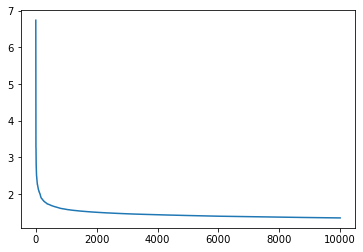

In [4]:
# sort scores in descending order in place in the df
df_anomalies.sort_values(by="score", ascending=False, inplace=True)
plt.plot(df_anomalies["score"].to_numpy())

Explore average patterns

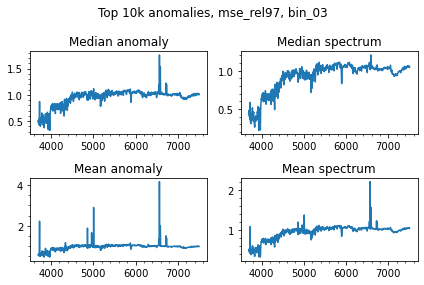

In [5]:
# average for top 10k anomalies
median_anomalous_spectrum = np.median(anomalies, axis=0)
mean_anomalous_spectrum = np.mean(anomalies, axis=0)

fig, axs = plt.subplots(2, 2, figsize=None, tight_layout=True)

# add title to the figure

fig.suptitle(
    f"Top 10k anomalies, {metric}, {bin_id}",
    fontsize=12
)

# add minor ticks for all axes
for ax in axs.flat:
    ax.minorticks_on()

axs[0, 0].plot(wave, median_anomalous_spectrum)
axs[0, 0].set_title("Median anomaly")

axs[1, 0].plot(wave, mean_anomalous_spectrum)
axs[1, 0].set_title("Mean anomaly")

axs[0, 1].plot(wave, median_spectrum)
axs[0, 1].set_title("Median spectrum")

axs[1, 1].plot(wave, mean_spectrum)
axs[1, 1].set_title("Mean spectrum")

# save median and mean spectra for later use
np.save(
    f"{data_directory}/median_anomalous_spectrum_10k.npy",
    median_anomalous_spectrum
)

np.save(
    f"{data_directory}/mean_anomalous_spectrum_10k.npy",
    mean_anomalous_spectrum
)

# save figure to pdf in Downloads folder
fig.savefig(
    f"{data_directory}/median_mean_anomalous_spectra_{bin_id}_10k.pdf"
)

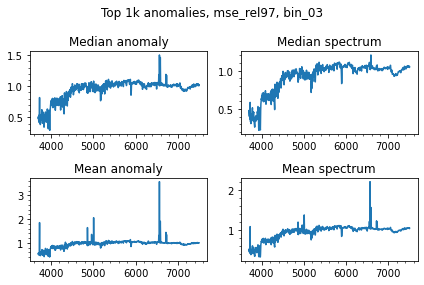

In [6]:
# average for top 1k anomalies
median_anomalous_spectrum_1k = np.median(anomalies[:1000], axis=0)
mean_anomalous_spectrum_1k = np.mean(anomalies[:1000], axis=0)

fig, axs = plt.subplots(2, 2, figsize=None, tight_layout=True)
# add title to the figure

fig.suptitle(
    f"Top 1k anomalies, {metric}, {bin_id}",
    fontsize=12
)
# add minor ticks for all axes
for ax in axs.flat:
    ax.minorticks_on()

axs[0, 0].plot(wave, median_anomalous_spectrum_1k)
axs[0, 0].set_title("Median anomaly")

axs[1, 0].plot(wave, mean_anomalous_spectrum_1k)
axs[1, 0].set_title("Mean anomaly")

axs[0, 1].plot(wave, median_spectrum)
axs[0, 1].set_title("Median spectrum")

axs[1, 1].plot(wave, mean_spectrum)
axs[1, 1].set_title("Mean spectrum")

# save median and mean spectra for later use
np.save(
    f"{data_directory}/median_anomalous_spectrum_1k.npy",
    median_anomalous_spectrum
)

np.save(
    f"{data_directory}/mean_anomalous_spectrum_1k.npy",
    mean_anomalous_spectrum
)

# save figure to pdf in Downloads folder
fig.savefig(
    f"{data_directory}/median_mean_anomalous_spectra_{bin_id}_1k.pdf"
)

## Explore explanations

In [27]:
%%capture output
# create array with weights for top all anomalies

explanations_directory = f"{data_directory}/000"

weights_all = np.empty(anomalies.shape)
non_vectorized_weights_all = []

for i, specobjid in enumerate(df_anomalies.index.to_numpy()):

    with open(
        f"{explanations_directory}/{specobjid}.pkl", "rb"
    ) as file:
        explanation = pickle.load(file)
        why = TellMeWhy(wave=wave, explanation=explanation)

        weights_all[i, :] = why.smooth_and_normalize_explanation()

        # there is only one label, since I have a regressor
        ind = why.explanation.top_labels[0]

        # Map each explanation weight to the corresponding superpixel
        dict_heatmap = dict(why.explanation.local_exp[ind])

        items = list(dict_heatmap.items())
        sorted_items = sorted(items, key=lambda x: x[0])
        values = [x[1] for x in sorted_items]

        segmented_heatmap = values
        non_vectorized_weights_all.append(segmented_heatmap)


        # tata.append(segmented_heatmap)


# new array to store the absolute values of the weights
weights_all_abs = np.abs(weights_all)

# save both arrays for later use

np.save(
    f"{data_directory}/weights_all.npy",
    weights_all
)

np.save(
    f"{data_directory}/weights_all_abs.npy",
    weights_all_abs
)


In [28]:
non_vectorized_weights_all[0]

[0.014257156247406307,
 -0.01783922215832004,
 -0.012503452722234135,
 -0.020465034641332296,
 -0.016025784713817035,
 -0.09867049195490199,
 -0.021867785266000403,
 -0.027757655022627444,
 -0.023015451287757432,
 -0.03438766955998079,
 -0.03558401177373616,
 -0.024503694617621516,
 -0.044986779848280124,
 -0.028269976001544805,
 -0.037486534338797506,
 -0.0214009592900434,
 -0.023307088579906633,
 -0.023225929964871675,
 -0.019383246161177432,
 -0.031192887929030768,
 -0.023886897768047147,
 0.001447129675630032,
 -0.02285137319830186,
 -0.02335261070132092,
 -0.009949951884277585,
 -0.017230739203879495,
 -0.013239442971611918,
 -0.013954253010319566,
 -0.007845714890002204,
 -0.004063209221297727,
 -0.01261546604990877,
 -0.010788341729748631,
 -0.0009535206855869507,
 -0.012076261148729969,
 -0.005953290639986337,
 -0.005293819489231596,
 -0.0029742284005973268,
 -0.0036057981542058637,
 -0.002632604391320182,
 -0.021299633051988655,
 -0.004721860986302911,
 -0.002515464745600366,


Summary stats of explanation weights

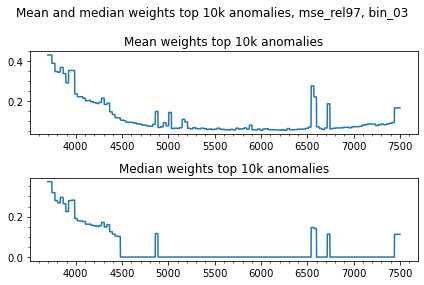

In [8]:
# mean and median of the explanation weights for all anomalies

mean_weigh_all_abs = np.mean(weights_all_abs, axis=0)
median_weigh_all_abs = np.median(weights_all_abs, axis=0)


# plot the mean and median of the weights
fig, axs = plt.subplots(2, 1, figsize=None, tight_layout=True)

# add title to the figure

fig.suptitle(
    f"Mean and median weights top 10k anomalies, {metric}, {bin_id}",
    fontsize=12
)

# add minor ticks for all axes
for ax in axs.flat:
    ax.minorticks_on()

axs[0].plot(wave, mean_weigh_all_abs)
axs[0].set_title("Mean weights top 10k anomalies")

axs[1].plot(wave, median_weigh_all_abs)
axs[1].set_title("Median weights top 10k anomalies")

# save figure to pdf in data directory

fig.savefig(
    f"{data_directory}/abs_mean_median_weights_top_10k_anomalies.pdf"
)


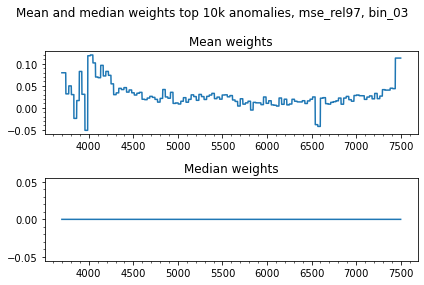

In [9]:
# repeat previous steps for but on the original weights_all array

mean_weigh_all = np.mean(weights_all, axis=0)
median_weigh_all = np.median(weights_all, axis=0)

fig, axs = plt.subplots(2, 1, figsize=None, tight_layout=True)

# add title to the figure

fig.suptitle(
    f"Mean and median weights top 10k anomalies, {metric}, {bin_id}",
    fontsize=12
)

# add minor ticks for all axes
for ax in axs.flat:
    ax.minorticks_on()

axs[0].plot(wave, mean_weigh_all)
axs[0].set_title("Mean weights")

axs[1].plot(wave, median_weigh_all)
axs[1].set_title("Median weights")

# save figure to pdf in data directory

fig.savefig(
    f"{data_directory}/mean_median_weights_top_10k_anomalies.pdf"
)


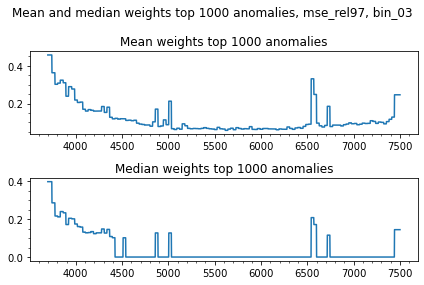

In [10]:
# mean and median of the explanation weights for the top 1000 anomalies

mean_weigh_top_1000 = np.mean(weights_all_abs[:1000], axis=0)
median_weigh_top_1000 = np.median(weights_all_abs[:1000], axis=0)

fig, axs = plt.subplots(2, 1, figsize=None, tight_layout=True)

# add title to the figure

fig.suptitle(
    f"Mean and median weights top 1000 anomalies, {metric}, {bin_id}",
    fontsize=12
)

# add minor ticks for all axes
for ax in axs.flat:
    ax.minorticks_on()

axs[0].plot(wave, mean_weigh_top_1000)
axs[0].set_title("Mean weights top 1000 anomalies")

axs[1].plot(wave, median_weigh_top_1000)
axs[1].set_title("Median weights top 1000 anomalies")

# save figure to pdf in data directory

fig.savefig(
    f"{data_directory}/abs_mean_median_weights_top_1000_anomalies.pdf"
)


## Inspect std of explanation weights

Text(0.5, 1.0, 'STD weights absolute values')

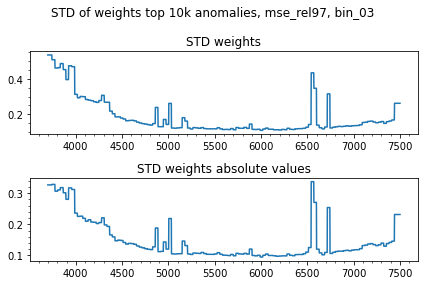

In [11]:
# compute sd of the weights along the wavelength axis

sd_weights_all = np.std(weights_all, axis=0)
sd_weights_all_abs = np.std(weights_all_abs, axis=0)

# plot the sd of the weights

fig, axs = plt.subplots(2, 1, figsize=None, tight_layout=True)

# add title to the figure

fig.suptitle(
    f"STD of weights top 10k anomalies, {metric}, {bin_id}",
    fontsize=12
)

# add minor ticks for all axes
for ax in axs.flat:
    ax.minorticks_on()

axs[0].plot(wave, sd_weights_all)
axs[0].set_title("STD weights")

axs[1].plot(wave, sd_weights_all_abs)
axs[1].set_title("STD weights absolute values")


Text(0.5, 1.0, 'STD weights absolute values')

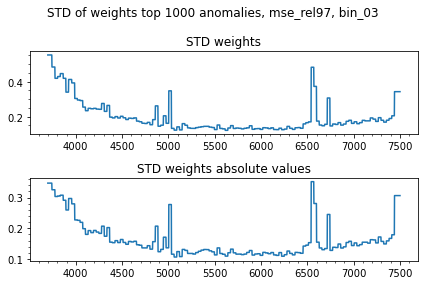

In [12]:
# compute standard deviation of the weights along the wavelength axis for the top 1000 anomalies

sd_weights_top_1000 = np.std(weights_all[:1000], axis=0)
sd_weights_top_1000_abs = np.std(weights_all_abs[:1000], axis=0)

# plot the sd of the weights

fig, axs = plt.subplots(2, 1, figsize=None, tight_layout=True)

# add title to the figure

fig.suptitle(
    f"STD of weights top 1000 anomalies, {metric}, {bin_id}",
    fontsize=12
)

# add minor ticks for all axes
for ax in axs.flat:
    ax.minorticks_on()

axs[0].plot(wave, sd_weights_top_1000)
axs[0].set_title("STD weights")

axs[1].plot(wave, sd_weights_top_1000_abs)
axs[1].set_title("STD weights absolute values")

